# Application to Metasurfaces and Lenses



In [98]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, exp, tan, log,log10,sqrt,squeeze,matmul
from numpy.linalg import inv

from mplcursors import cursor  # separate package must be installed

from bookfuncs.py.simuParams import  SimuParam
from bookfuncs.py.PlotData.plotfunc import *
import skrf as rf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

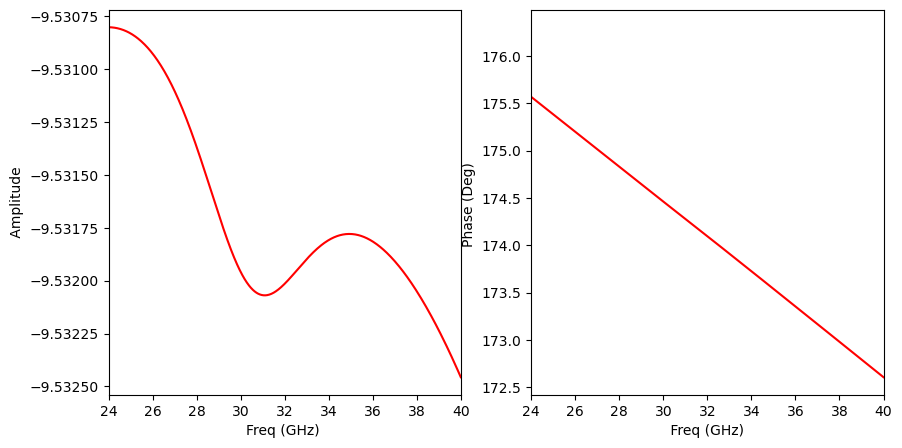

In [2]:
#https://community.altair.com/discussion/33258/a-metamaterial-inspired-single-split-ring-resonator-for-sensing-applications-a-practical-design-approach#:~:text=Split%20ring%20resonators%20(SRR)%20consists%20of%20two,can%20be%20represented%20by%20the%20following%20equation.

Path="CSTFiles/UnitCell/Sheet_R376ab_Lo4_Dport_Lo150.s4p"

def s4pFromCSTUnitCell(Path,Type):
    if Type=="PolY":
        p1,p2=(0,2)
    if Type=="PolX":
        p1,p2=(1,3)
    unitcell = rf.Network(Path)
    S11=np.squeeze(unitcell.s[:,p1,p1])
    S21=np.squeeze(unitcell.s[:,p2,p1])
    S12=np.squeeze(unitcell.s[:,p1,p2])
    S22=np.squeeze(unitcell.s[:,p2,p2])
    f=unitcell.f
    stemp=np.array([[S11,S12],
                [S21,S22]])
    Sp=np.transpose(stemp)

    return f,Sp
Z0=376.73
f,SpYPol=s4pFromCSTUnitCell(Path,'PolY')
f,SpXPol=s4pFromCSTUnitCell(Path,'PolX')
ntwSpYPol = rf.Network(frequency=f, s=SpYPol,z0=[Z0,Z0])
ABCDYPol=rf.s2a(SpYPol,z0=376.73)


fig2,ax=plt.subplots(1,2)
fig2.set_size_inches((10,5))

plot1DSparametricdB(ax,f,[24,40],(0,SpXPol[:,1,1],'r','-') )


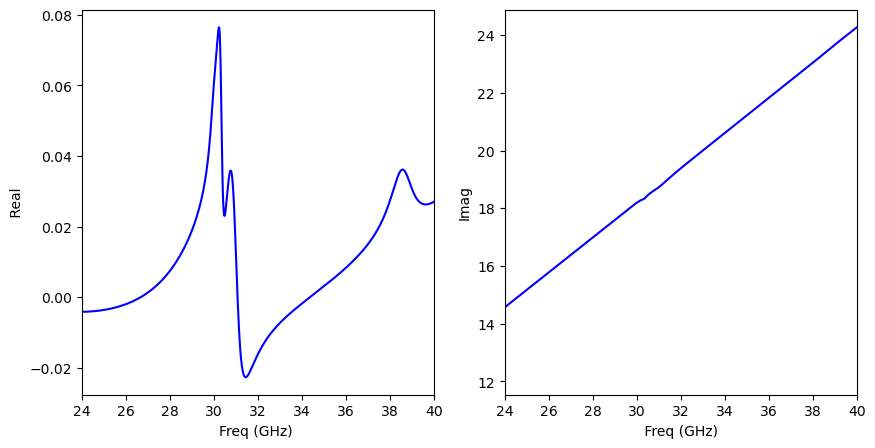

In [3]:
fig2,ax=plt.subplots(1,2)
fig2.set_size_inches((10,5))
# plot1DSparametricReIm(ax,f,[24,40],(0,ABCDYPol[:,0,0],'b','-'),
#                                 (0,ABCDYPol[:,0,1],'r','-'),
#                                 (0,ABCDYPol[:,1,0],'g','-'),
#                                (0,ABCDYPol[:,1,1],'m','-')
#                        )
plot1DSparametricReIm(ax,f,[24,40],(0,ABCDYPol[:,0,1],'b','-')
                       )


## De-embeding Free Space TL

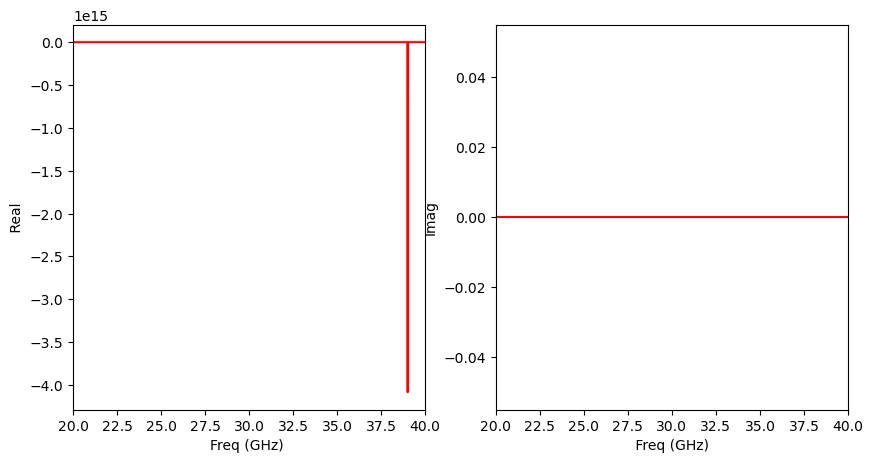

In [126]:
Path="CSTFiles/UnitCell/Sheet_R376ab_Lo4Deembed.s4p"
par=SimuParam()
par.set_empar(id=0,er=1,ur=1,sig=0)
ftarget=26e9
Lamb=1/sqrt(par.emconst['e0']*par.emconst['u0'])/ftarget
Z0=376.73
Y0=1/Z0
LLength=Lamb/2

def s4pFromCSTUnitCell(Path,Type):
    if Type=="PolY":
        p1,p2=(0,2)
    if Type=="PolX":
        p1,p2=(1,3)
    unitcell = rf.Network(Path)
    S11=np.squeeze(unitcell.s[:,p1,p1])
    S21=np.squeeze(unitcell.s[:,p2,p1])
    S12=np.squeeze(unitcell.s[:,p1,p2])
    S22=np.squeeze(unitcell.s[:,p2,p2])
    f=unitcell.f
    stemp=np.array([[S11,S12],
                [S21,S22]])
    Sp=np.transpose(stemp)

    return f,Sp

def airTLNtw(f,LLength,par):
    Beta=2*pi*f*sqrt(par.emconst['e0']*par.emconst['u0'])   
    S11=exp(-1j*Beta*LLength)
    S21=np.zeros(Beta.shape)
    S12=np.zeros(Beta.shape)
    S22=exp(-1j*Beta*LLength)
    Stemp=np.array([[S11,S12],
                [S21,S22]])
    Sp=np.transpose(Stemp)
    ntw= rf.Network(frequency=f, s=Sp,z0=[Z0,Z0])
    return  ntw

f,SpYPolEmb=s4pFromCSTUnitCell(Path,'PolY')
ntwSpYPolEmb = rf.Network(frequency=f, s=SpYPolEmb,z0=[Z0,Z0])
ntwAir=airTLNtw(f,LLength,par)
SpYPol=np.zeros(ntwSpYPolEmb.s.shape)
for idf in range(0,len(f),1):
    SpYPol[idf,:,:]=matmul(inv(squeeze(ntwAir.s[idf,:,:])),squeeze(ntwSpYPolEmb.s[idf,:,:]))
    SpYPol[idf,:,:]=matmul(squeeze(SpYPol[idf,:,:]),inv(squeeze(ntwAir.s[idf,:,:])))

# ntwSpYPol=ntwAir.inv**ntwSpYPolEmb**ntwAir.inv
ABCDYPol=rf.s2a(SpYPol,z0=376.73)


fig2,ax=plt.subplots(1,2)
fig2.set_size_inches((10,5))

plot1DSparametricReIm(ax,f,[20,40],(0,ABCDYPol[:,0,0],'r','-') )

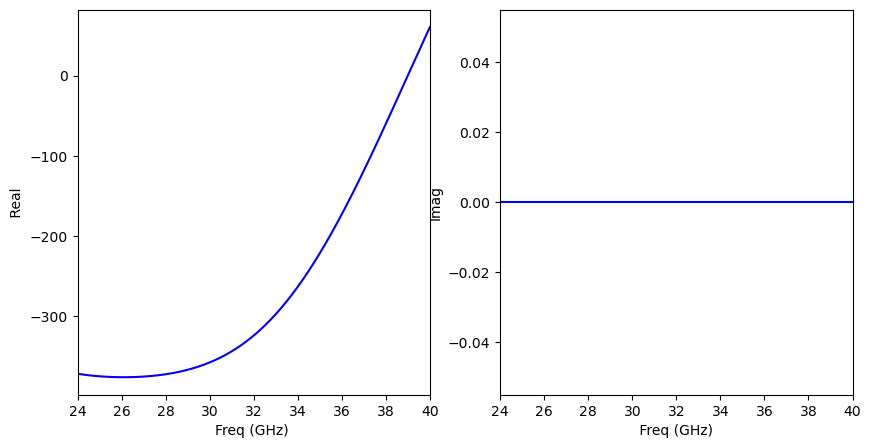

In [127]:
## ABCD to T mpedances
# Z3=1/C
Z3=1/ABCDYPol[:,1,0]
# Z1=(A-1)*Z3
Z1=(ABCDYPol[:,0,0]-1)*Z3
# Z2=(D-1)*Z3
Z2=(ABCDYPol[:,1,1]-1)*Z3


fig2,ax=plt.subplots(1,2)
fig2.set_size_inches((10,5))
plot1DSparametricReIm(ax,f,[24,40],(0,Z3,'b','-')
                       )

In [97]:
# val=np.matmult(np.linalg.inv(ntwAir.s),ntwSpYPolEmb.s)
A=np.array([[[1,0],[0,1]],[[1,0],[0,1]],[[1,0],[0,1]]])
A.shape
A=np.transpose(A)
B=np.array([[[1,1],[1,1]],[[2,2],[2,2]],[[3,3],[3,3]]])
B=np.transpose(B)

Sol=np.tensordot(A,B,axes=([0,1]))

Sol.shape


(2, 3, 2, 3)